In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pathlib
import copy

In [2]:
path = pathlib.Path(os.path.normpath("C:/Users/shruti/Deep_learning_projects/Cat Dog classifier/"))
path

WindowsPath('C:/Users/shruti/Deep_learning_projects/Cat Dog classifier')

#### PREPARING OUR DATA

In [3]:
train_path = path/'dataset/training_set'
val_path = path/'dataset/test_set'

In [4]:
transform = transforms.Compose([transforms.Resize((256,256)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [5]:
#loading the folders
train = datasets.ImageFolder(train_path, transform = transform)
val = datasets.ImageFolder(val_path, transform=transform)

In [6]:
#loading the dataset
batch_size = 4
train_set = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle = True)
val_set = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle=True)

In [7]:
#defining the classes of our dataset
classes = ('cat','dog')

In [8]:
#using GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### VISUALIZING THE DATASET


In [9]:
def imshow(image, title = None):
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    image = image*std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title is not None:
        print(title)
    plt.pause(0.001)

['dog', 'dog', 'cat', 'cat']


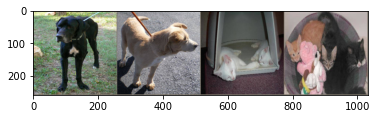

In [10]:
#getting a batch of training data
images, labels = next(iter(train_set))
out = torchvision.utils.make_grid(images)
imshow(out,title=[classes[x] for x in labels])

dog


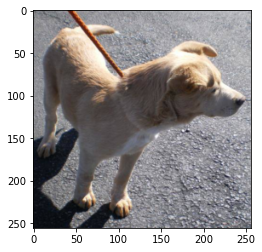

In [11]:
imshow(images[1],classes[labels[1]])

#### TRAINING OUR MODEL

In [24]:
def train_model(model, criterion, optimizer,scheduler, num_epochs):
    since = time.time()
    best_acc = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("-"*20)
        
        model.train()
        
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for images, labels in (train_set):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(images)
            _,predicted = torch.max(output,1)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()*images.size(0)
            running_correct += torch.sum(predicted==labels.data)
            total += labels.size(0)
            
        scheduler.step()
        
        epoch_loss = running_loss/len(train_set)
        epoch_acc = running_correct.double()/total
        print("Loss: {:.4f}  Accuracy:{:.4f}".format(epoch_loss, epoch_acc))
        print()
        
        if epoch_acc>best_acc:
            best_acc = epoch_acc
            best_model_weights = copy.deepcopy(model.state_dict())
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model

In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_set):
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            _,pred = torch.max(output, 1)
            
            for i in range(num_images):
                images_so_far+=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("predicted: {}".format(classes[pred[i]]))
                imshow(images.cpu().data[i])
                
                if images_so_far==num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

#### FEATURE EXTRACTION
Here we dont backprop the network and use only the last layers for our prediction

In [26]:
model = torchvision.models.resnet18(pretrained=True)
for parameter in model.parameters():
    parameter.requries_grad = False
    
num_filters = model.fc.in_features
model.fc = nn.Linear(num_filters, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum =0.9)

scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma=0.1)

In [27]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs = 10)

Epoch 1/10
--------------------
Loss: 1.2513  Accuracy:0.8884

Epoch 2/10
--------------------
Loss: 0.4918  Accuracy:0.9535

Epoch 3/10
--------------------
Loss: 0.1840  Accuracy:0.9846

Epoch 4/10
--------------------
Loss: 0.1014  Accuracy:0.9916

Epoch 5/10
--------------------
Loss: 0.0854  Accuracy:0.9928

Epoch 6/10
--------------------
Loss: 0.0583  Accuracy:0.9960

Epoch 7/10
--------------------
Loss: 0.0579  Accuracy:0.9960

Epoch 8/10
--------------------
Loss: 0.0252  Accuracy:0.9984

Epoch 9/10
--------------------
Loss: 0.0149  Accuracy:0.9994

Epoch 10/10
--------------------
Loss: 0.0120  Accuracy:0.9998

Training complete in 74m 10s


In [28]:
save_path = "./featureextract_model"
torch.save(model.state_dict(), save_path)

In [29]:
save_path = "./finetuning_model"
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [30]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### validating our dataset

In [31]:
correct = 0.0
total = 0.0
with torch.no_grad():
    for (images, labels) in val_set:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _,predicted = torch.max(output, 1)
        correct+=torch.sum(predicted==labels.data)
        total+=labels.size(0)
print("The validation acc: {:.4f}".format(correct/total))

The validation acc: 0.9855


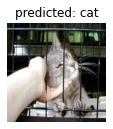

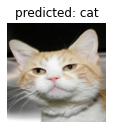

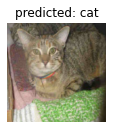

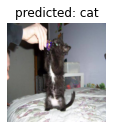

In [33]:
visualize_model(model,4)

#### ACCURACY OF EACH VLASS

In [34]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in val_set:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   cat : 99 %
Accuracy of   dog : 98 %
